In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime

matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')

In [3]:
import nsfg
df = nsfg.ReadFemPreg()


In [4]:
live = df[df.outcome == 1]
len(live)

9148

In [5]:
firsts = df[df.birthord==1]
others = df[df.birthord>1]
len(firsts), len(others)

(4413, 4735)

In [6]:
a = firsts.prglngth.mean()
b = others.prglngth.mean()

c = (a - b)*168.0

print("Mean pregnancy length for first borns: {}".format(a))
print("Mean pregnancy length for others: {}".format(b))
print("Difference between mean first and others pregnancy lengths in hrs: {}".format(c))

Mean pregnancy length for first borns: 38.60095173351461
Mean pregnancy length for others: 38.52291446673706
Difference between mean first and others pregnancy lengths in hrs: 13.11026081862832


In [7]:
def get_value(vals):
    import random
    pval = random.uniform(0,100)
    #print(pval)
    return np.percentile(vals,pval)


def get_group(vals, numberofsubjects):
    """Returns a pandas series."""
    import random
    a = list()
    for i in range(numberofsubjects):
        try:
            b = get_value(vals)
            a.append(b)
        except:
            pass
    c = pd.Series(a)
    return c

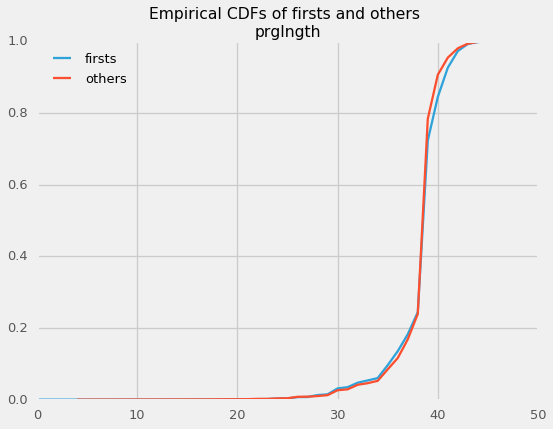

In [8]:

firsts_data = firsts.prglngth.value_counts(normalize=True).sort_index().cumsum()
others_data = others.prglngth.value_counts(normalize=True).sort_index().cumsum()

dfdata = pd.DataFrame({'firsts': firsts_data,
                     'others': others_data})
dfdata = dfdata.fillna(method='ffill')
dfdata.plot(figsize=(8,6), title = "Empirical CDFs of firsts and others \n" + 
           "prglngth");

In [9]:
firsts_prglngth_vals = firsts.prglngth.values
others_prglngth_vals = others.prglngth.values

firstssamp = get_group(firsts_prglngth_vals, 150000)
otherssamp = get_group(others_prglngth_vals, 150000)

In [10]:
(firstssamp > otherssamp).values.mean()


0.37891333333333332

## <font color='steelblue'>The Estimation Game</font>

```
Let’s play a game. I think of a distribution, and you have to guess what it is. I’ll give you two hints: it’s a normal distribution, and here’s a random sample drawn from it:
[-0.441, 1.774, -0.101, -1.138, 2.975, -2.138]

What do you think is the mean parameter, µ, of this distribution?

One choice is to use the sample mean, x, as an estimate of µ. In this example, x is 0.155, so it would be reasonable to guess µ = 0.155. This process is called estimation, and the statistic we used (the sample mean) is called an estimator.
```

In [11]:
nums = [-0.441, 1.774, -0.101, -1.138, 2.975, -2.138]

numser = pd.Series(nums)
numser.mean()

0.15516666666666667

In [13]:
import scipy
results = scipy.stats.bayes_mvs(numser.as_matrix())
results

(Mean(statistic=0.15516666666666667, minmax=(-1.4023849490394598, 1.7127182823727924)),
 Variance(statistic=5.9746702777777765, minmax=(1.6190790450036288, 15.647649794494102)),
 Std_dev(statistic=2.2519897075579607, minmax=(1.2724303694126562, 3.9557110352620684)))

If there are no outliers, the sample mean minimizes the **mean squared error** (MSE). That is, if we play the game many times, and each time compute the error $\bar{x} - \mu$, the sample mean minimizes:

$
MSE = \frac{1}{m} \sum (\bar{x} - \mu)^{2}
$

where $m$ is the number of times you play the estimation game, not to be confused with $n$, which is the size of the sample used to compute $\bar{x}$.



In [14]:
import math

def RMSE(estimates, actual):
    e2 = [(estimate-actual)**2 for estimate in estimates]
    mse = np.mean(e2)
    return math.sqrt(mse)

In [21]:
def Estimate1(n=7, m=1000):
    import random
    mu = 0
    sigma = 1

    means = []
    medians = []
    for _ in range(m):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        xbar = np.mean(xs)
        median = np.median(xs)
        means.append(xbar)
        medians.append(median)

    print('rmse xbar', RMSE(means, mu))
    print('rmse median', RMSE(medians, mu))

Again, $n$ is the size of the sample, and $m$ is the number of times we play the game. ```means``` is the list of estimates based on $\bar{x}$. ```medians``` is the list of medians. 

In the function ```RMSE```, ```estimates``` is the list of estimates, ```actual``` is the actual thing being estimated. In practice, of course, we don't know ```actual```; if we did, we wouldn't have to estimate it. The purpose of the experiment is to compare the performance of the two estimators.

In [22]:
Estimate1()

rmse xbar 0.3837896535522685
rmse median 0.4625434945810025


When I ran this code, the RMSE of the sample mean was 0.3837, which means that if we $\bar{x}$ to estimate the mean of this distribution, based on a sample with $n=7$, we should expect to be off by 0.3837 on average. Using the median to estimate the mean yields RMSE of 0.46254, which confirms that $\bar{x}$ yields lower RMSE, at least for this example.


Minimizing MSE is a nice property, but it's not always the best strategy. For example, suppose we are estimating the distribution of wind speeds at a building site. If the estimate is too high, we might overbuild the structure, increasing its cost. But if it's too low, the building might collapse. Because cost as a function of error is not symmetric, minimizing MSE is not the best strategy.

AS another exmaple, suppose I roll three six-sided dice and ask you to predict the total. If you get it exactly right, you get a prize; otherwise you get nothing. In this case the value that minimizes the MSE is 10.5

In [25]:
def Dice_3_6(trials = 800000, n=3):
    import random
    totals = []
    dicevalues = range(1,7)
    for _ in range(trials):
        rolls = [random.choice(dicevalues) for i in range(n)]
        total = np.sum(rolls)
        totals.append(total)

    print('average of the total of rolling three dice', np.mean(totals))
    totalsser = pd.Series(totals)
    print(totalsser.value_counts(normalize=True))

In [26]:
Dice_3_6()

average of the total of rolling three dice 10.50150125
10    0.125825
11    0.125584
9     0.115679
12    0.115414
13    0.097589
8     0.096729
14    0.069440
7     0.069282
6     0.046294
15    0.046170
5     0.027856
16    0.027690
17    0.013705
4     0.013491
3     0.004666
18    0.004586
dtype: float64
